In [1]:
# If running locally
!pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys
sys.path.append(".")

from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset
from src.models.unet_convlstm_unc import UNetConvLSTMUncertainty, gaussian_nll


In [2]:
import numpy as np

In [3]:
data_path = "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents_uncertainty/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1771446846329.nc"

uv, time, lat, lon = load_cmems_uv(
    data_path,
    u_var="utotal",
    v_var="vtotal",
    depth_index=0,
    regrid_hw=(64,64)   # optional but recommended
)

print(uv.shape)  # (T,2,H,W)


(17545, 2, 64, 64)


In [ ]:
# from src.data.cmems_dataset import compute_minmax, apply_minmax

seq_len = 12

split_t = int(len(uv)*0.7)
uv_train = uv[:split_t]
uv_val = uv[split_t:]

# stats = compute_minmax(uv_train)
# uv_train_n = apply_minmax(uv_train, stats)
# uv_val_n = apply_minmax(uv_val, stats)

# train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=seq_len)
# val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=seq_len)


In [12]:

class ZScoreStats:
    def __init__(self, u_mean, u_std, v_mean, v_std):
        self.u_mean = u_mean
        self.u_std = u_std
        self.v_mean = v_mean
        self.v_std = v_std

def compute_zscore(uv):
    # uv: (T,2,H,W)
    u = uv[:,0]
    v = uv[:,1]

    u_mean = np.mean(u)
    u_std  = np.std(u) + 1e-8
    v_mean = np.mean(v)
    v_std  = np.std(v) + 1e-8

    return ZScoreStats(u_mean, u_std, v_mean, v_std)

def apply_zscore(uv, stats):
    uv_n = uv.copy()
    uv_n[:,0] = (uv_n[:,0] - stats.u_mean) / stats.u_std
    uv_n[:,1] = (uv_n[:,1] - stats.v_mean) / stats.v_std
    return uv_n


In [13]:
stats = compute_zscore(uv_train)
uv_train_n = apply_zscore(uv_train, stats)
uv_val_n   = apply_zscore(uv_val, stats)

train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=seq_len)
val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=seq_len)

In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader

# -----------------------------
# Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, flush=True)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

model = UNetConvLSTMUncertainty(base_ch=32, lstm_ch=256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def rmse(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2))

run_dir = "runs/convlstm_unc_seqlen12"
os.makedirs(run_dir, exist_ok=True)

best_path    = os.path.join(run_dir, "best.pt")          # best (model-only)
final_path   = os.path.join(run_dir, "final.pt")         # final (full)
history_path = os.path.join(run_dir, "history.jsonl")    # fast append log

# overwrite history each run (optional)
if os.path.exists(history_path):
    os.remove(history_path)

best_val_rmse = float("inf")
epochs = 100

val_every   = 5     # <-- validate every N epochs
ckpt_every  = 25    # <-- full resume checkpoint every N epochs

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    # -------- Train --------
    model.train()
    train_loss_sum = 0.0
    n_train = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        mu, logvar = model(X)
        loss = gaussian_nll(mu, logvar, Y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        bs = X.size(0)
        train_loss_sum += loss.item() * bs
        n_train += bs

    train_nll = train_loss_sum / max(n_train, 1)

    # -------- Validate (less often) --------
    did_val = (epoch % val_every == 0) or (epoch == epochs - 1)
    if did_val:
        model.eval()
        val_rmse_sum = 0.0
        n_val = 0

        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                mu, logvar = model(X)

                batch_rmse = rmse(mu, Y)
                bs = X.size(0)
                val_rmse_sum += batch_rmse.item() * bs
                n_val += bs

        val_rmse_avg = val_rmse_sum / max(n_val, 1)
    else:
        val_rmse_avg = float("nan")

    # -------- Log --------
    if did_val:
        print(f"Epoch {epoch:04d}: train_nll={train_nll:.6f}  val_rmse={val_rmse_avg:.6f}", flush=True)
    else:
        print(f"Epoch {epoch:04d}: train_nll={train_nll:.6f}  (no val)", flush=True)

    # -------- Fast history logging (append 1 line) --------
    row = {
        "epoch": int(epoch),
        "train_nll": float(train_nll),
        "val_rmse": (None if not did_val else float(val_rmse_avg)),
        "lr": float(opt.param_groups[0]["lr"]),
    }
    with open(history_path, "a") as f:
        f.write(json.dumps(row) + "\n")

    # -------- Save best (MODEL ONLY, only when we validated) --------
    if did_val and val_rmse_avg < best_val_rmse:
        best_val_rmse = val_rmse_avg
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "best_val_rmse": float(best_val_rmse),
                "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
                "seq_len": seq_len,
            },
            best_path,
        )
        print(f"  Saved new best (model-only) -> {best_path}", flush=True)

    # -------- Periodic FULL checkpoint (for resume) --------
    if ckpt_every and epoch > 0 and epoch % ckpt_every == 0:
        ckpt_path = os.path.join(run_dir, f"checkpoint_epoch_{epoch}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": opt.state_dict(),
                "best_val_rmse": (None if best_val_rmse == float("inf") else float(best_val_rmse)),
                "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
                "seq_len": seq_len,
            },
            ckpt_path,
        )
        print(f"  Saved periodic FULL checkpoint -> {ckpt_path}", flush=True)

# -----------------------------
# Save final (FULL)
# -----------------------------
torch.save(
    {
        "epoch": epochs - 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "best_val_rmse": (None if best_val_rmse == float("inf") else float(best_val_rmse)),
        "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
        "seq_len": seq_len,
    },
    final_path,
)

print(f"Training done. Best val_rmse={best_val_rmse:.6f}", flush=True)
print(f"Best checkpoint (model-only): {best_path}", flush=True)
print(f"Final checkpoint (full):      {final_path}", flush=True)
print(f"History (JSONL):              {history_path}", flush=True)


Using device: cuda
Epoch 0000: train_nll=-1.078262  val_rmse=0.156269
  Saved new best (model-only) -> runs/convlstm_unc_new/best.pt
Epoch 0001: train_nll=-1.435180  (no val)
Epoch 0002: train_nll=-1.559220  (no val)
Epoch 0003: train_nll=-1.708197  (no val)
Epoch 0004: train_nll=-1.842041  (no val)
Epoch 0005: train_nll=-1.910443  val_rmse=0.121750
  Saved new best (model-only) -> runs/convlstm_unc_new/best.pt
Epoch 0006: train_nll=-1.964114  (no val)
Epoch 0007: train_nll=-2.006111  (no val)
Epoch 0008: train_nll=-2.040811  (no val)
Epoch 0009: train_nll=-2.076628  (no val)
Epoch 0010: train_nll=-2.097939  val_rmse=0.126912
Epoch 0011: train_nll=-2.123044  (no val)
Epoch 0012: train_nll=-2.142691  (no val)
Epoch 0013: train_nll=-2.161837  (no val)
Epoch 0014: train_nll=-2.184966  (no val)
Epoch 0015: train_nll=-2.200299  val_rmse=0.123162
Epoch 0016: train_nll=-2.217384  (no val)
Epoch 0017: train_nll=-2.238641  (no val)
Epoch 0018: train_nll=-2.242926  (no val)
Epoch 0019: train_nll

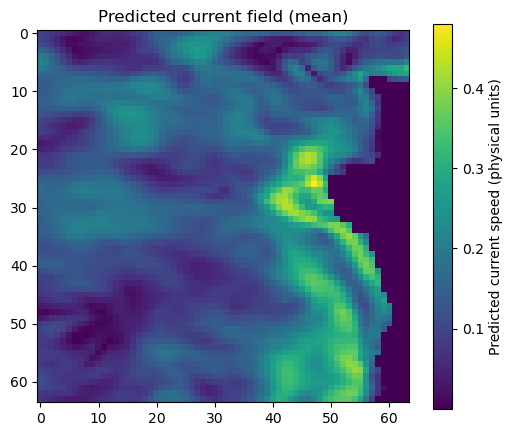

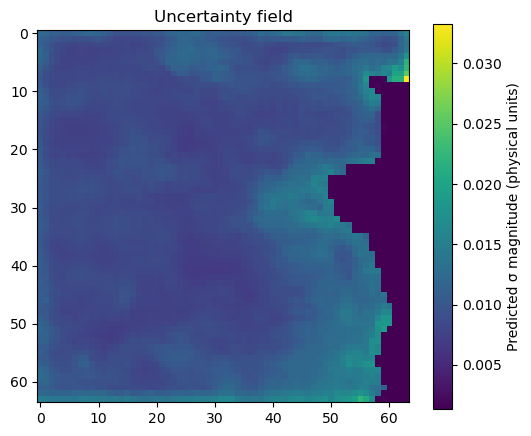

In [13]:
t = 100
X = uv_val_n[t-seq_len:t]   # still normalized inputs (z-score)

with torch.no_grad():
    mu, logvar = model(torch.tensor(X[None]).to(device))
    mu = mu.cpu().numpy()[0]                      # (2,H,W) mean (z-score units)
    sigma = torch.exp(0.5 * logvar).cpu().numpy()[0]  # (2,H,W) std-dev (z-score units)

# ---- de-normalize mean back to physical units ----
u_mu = mu[0] * stats.u_std + stats.u_mean
v_mu = mu[1] * stats.v_std + stats.v_mean

# ---- convert sigma to physical units ----
u_sigma = sigma[0] * stats.u_std
v_sigma = sigma[1] * stats.v_std

speed = np.sqrt(u_mu**2 + v_mu**2)
unc = np.sqrt(u_sigma**2 + v_sigma**2)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(speed)
plt.colorbar(label="Predicted current speed (physical units)")
plt.title("Predicted current field (mean)")
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(unc)
plt.colorbar(label="Predicted σ magnitude (physical units)")
plt.title("Uncertainty field")
plt.show()


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best checkpoint
checkpoint = torch.load("runs/convlstm_unc_seqlen12/best.pt", map_location=device)

model = UNetConvLSTMUncertainty(base_ch=32, lstm_ch=256).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Optionally restore stats and seq_len from checkpoint
# stats_dict = checkpoint["stats"]
# stats = ZScoreStats(**stats_dict)
# seq_len = checkpoint["seq_len"]

print(f"Loaded best model from epoch {checkpoint['epoch']}, val_rmse={checkpoint['best_val_rmse']:.6f}")

Loaded best model from epoch 20, val_rmse=0.117535


/tmp/ipykernel_5167/4135556296.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("runs/convlstm_unc_new/best.pt", map_location=device)


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Helper to un-normalize data back to m/s
def inverse_zscore(img_norm, stats):
    """
    Reverts Z-score normalization.
    img_norm: (2, H, W)
    """
    # Move to CPU numpy if it's a tensor
    if isinstance(img_norm, torch.Tensor):
        img_norm = img_norm.cpu().numpy()
        
    img_phys = np.zeros_like(img_norm)
    img_phys[0] = img_norm[0] * stats.u_std + stats.u_mean
    img_phys[1] = img_norm[1] * stats.v_std + stats.v_mean
    return img_phys

# # 2. Autoregressive Rollout Function
# def predict_autoregressive(model, initial_seq, steps=12, device='cuda'):
#     """
#     Predicts 'steps' into the future by feeding predictions back as inputs.
#     initial_seq: Input tensor of shape (1, seq_len, 2, H, W)
#     """
#     model.eval()
#     current_seq = initial_seq.clone().to(device)
#     predictions = []
    
#     with torch.no_grad():
#         for _ in range(steps):
#             # Predict next step (mu, logvar)
#             mu, logvar = model(current_seq)
            
#             # Store prediction (mu is the predicted mean current)
#             # mu shape: (1, 2, H, W) -> Store as (2, H, W)
#             predictions.append(mu.cpu().numpy()[0])
            
#             # Update sequence: remove oldest frame, add new prediction
#             # Need to reshape mu to (1, 1, 2, H, W) for concatenation
#             next_frame = mu.unsqueeze(1)
#             current_seq = torch.cat([current_seq[:, 1:], next_frame], dim=1)
            
    return np.array(predictions) # Shape: (steps, 2, H, W)

def predict_autoregressive(model, initial_seq, steps=12, device='cuda'):
    model.eval()
    current_seq = initial_seq.clone().to(device)
    predictions = []
    uncertainties = []
    
    with torch.no_grad():
        for _ in range(steps):
            mu, logvar = model(current_seq)
            
            predictions.append(mu.cpu().numpy()[0])           # (2, H, W)
            sigma = torch.exp(0.5 * logvar)                   # std-dev in normalized space
            uncertainties.append(sigma.cpu().numpy()[0])       # (2, H, W)
            
            # Feed the MEAN back as the next input
            next_frame = mu.unsqueeze(1)
            current_seq = torch.cat([current_seq[:, 1:], next_frame], dim=1)
            
    return np.array(predictions), np.array(uncertainties)  # both (steps, 2, H, W)

def inverse_zscore_sigma(sigma_norm, stats):
    """Convert normalized std-dev to physical units."""
    if isinstance(sigma_norm, torch.Tensor):
        sigma_norm = sigma_norm.cpu().numpy()
    sigma_phys = np.zeros_like(sigma_norm)
    sigma_phys[0] = sigma_norm[0] * stats.u_std
    sigma_phys[1] = sigma_norm[1] * stats.v_std
    return sigma_phys

In [14]:
sample_idx = 50
steps_to_plot = [1, 6, 12]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Get input from validation set
input_tensor, _ = val_ds[sample_idx]

if isinstance(input_tensor, np.ndarray):
    input_seq = torch.from_numpy(input_tensor).unsqueeze(0).float()
else:
    input_seq = input_tensor.unsqueeze(0).float()

input_seq = input_seq.to(device)

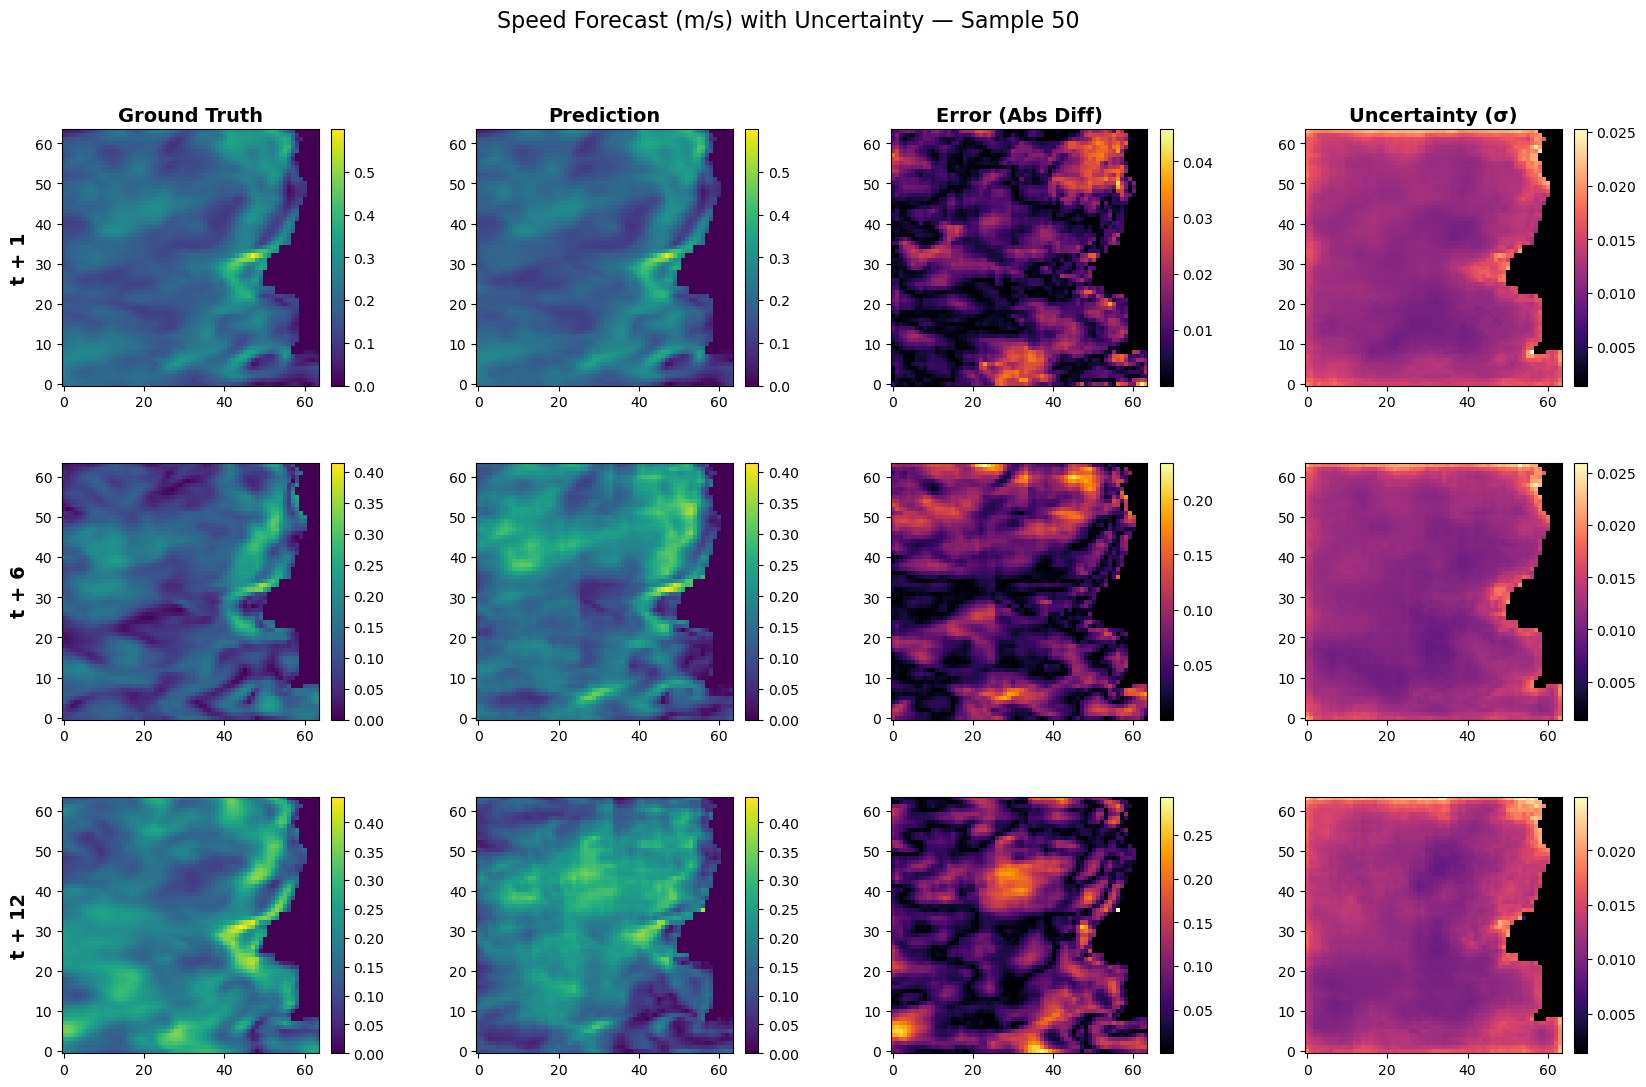

In [15]:
# 2. Generate predictions WITH uncertainty
preds_norm, sigmas_norm = predict_autoregressive(model, input_seq, steps=12, device=device)

# 3. Setup Plot — 4 columns now
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.35)
cols = ['Ground Truth', 'Prediction', 'Error (Abs Diff)', 'Uncertainty (σ)']
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

for i, t_step in enumerate(steps_to_plot):
    pred_idx = t_step - 1
    gt_idx = sample_idx + seq_len + (t_step - 1)

    # Prediction (de-normalized)
    pred_uv = inverse_zscore(preds_norm[pred_idx], stats)
    # Ground truth
    gt_uv = uv_val[gt_idx]
    # Uncertainty (de-normalized)
    sigma_uv = inverse_zscore_sigma(sigmas_norm[pred_idx], stats)

    # Speed magnitudes
    speed_pred = np.sqrt(pred_uv[0]**2 + pred_uv[1]**2)
    speed_gt   = np.sqrt(gt_uv[0]**2 + gt_uv[1]**2)
    speed_err  = np.abs(speed_pred - speed_gt)
    # Uncertainty magnitude (propagated to speed space)
    speed_unc  = np.sqrt(sigma_uv[0]**2 + sigma_uv[1]**2)

    vmin = min(speed_gt.min(), speed_pred.min())
    vmax = max(speed_gt.max(), speed_pred.max())

    # Ground Truth
    im1 = axes[i, 0].imshow(speed_gt, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[i, 0].set_ylabel(f"t + {t_step}", fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # Prediction
    im2 = axes[i, 1].imshow(speed_pred, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Error
    im3 = axes[i, 2].imshow(speed_err, cmap='inferno', origin='lower')
    plt.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

    # Uncertainty
    im4 = axes[i, 3].imshow(speed_unc, cmap='magma', origin='lower')
    plt.colorbar(im4, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.suptitle(f"Speed Forecast (m/s) with Uncertainty — Sample {sample_idx}", fontsize=16)
plt.show()

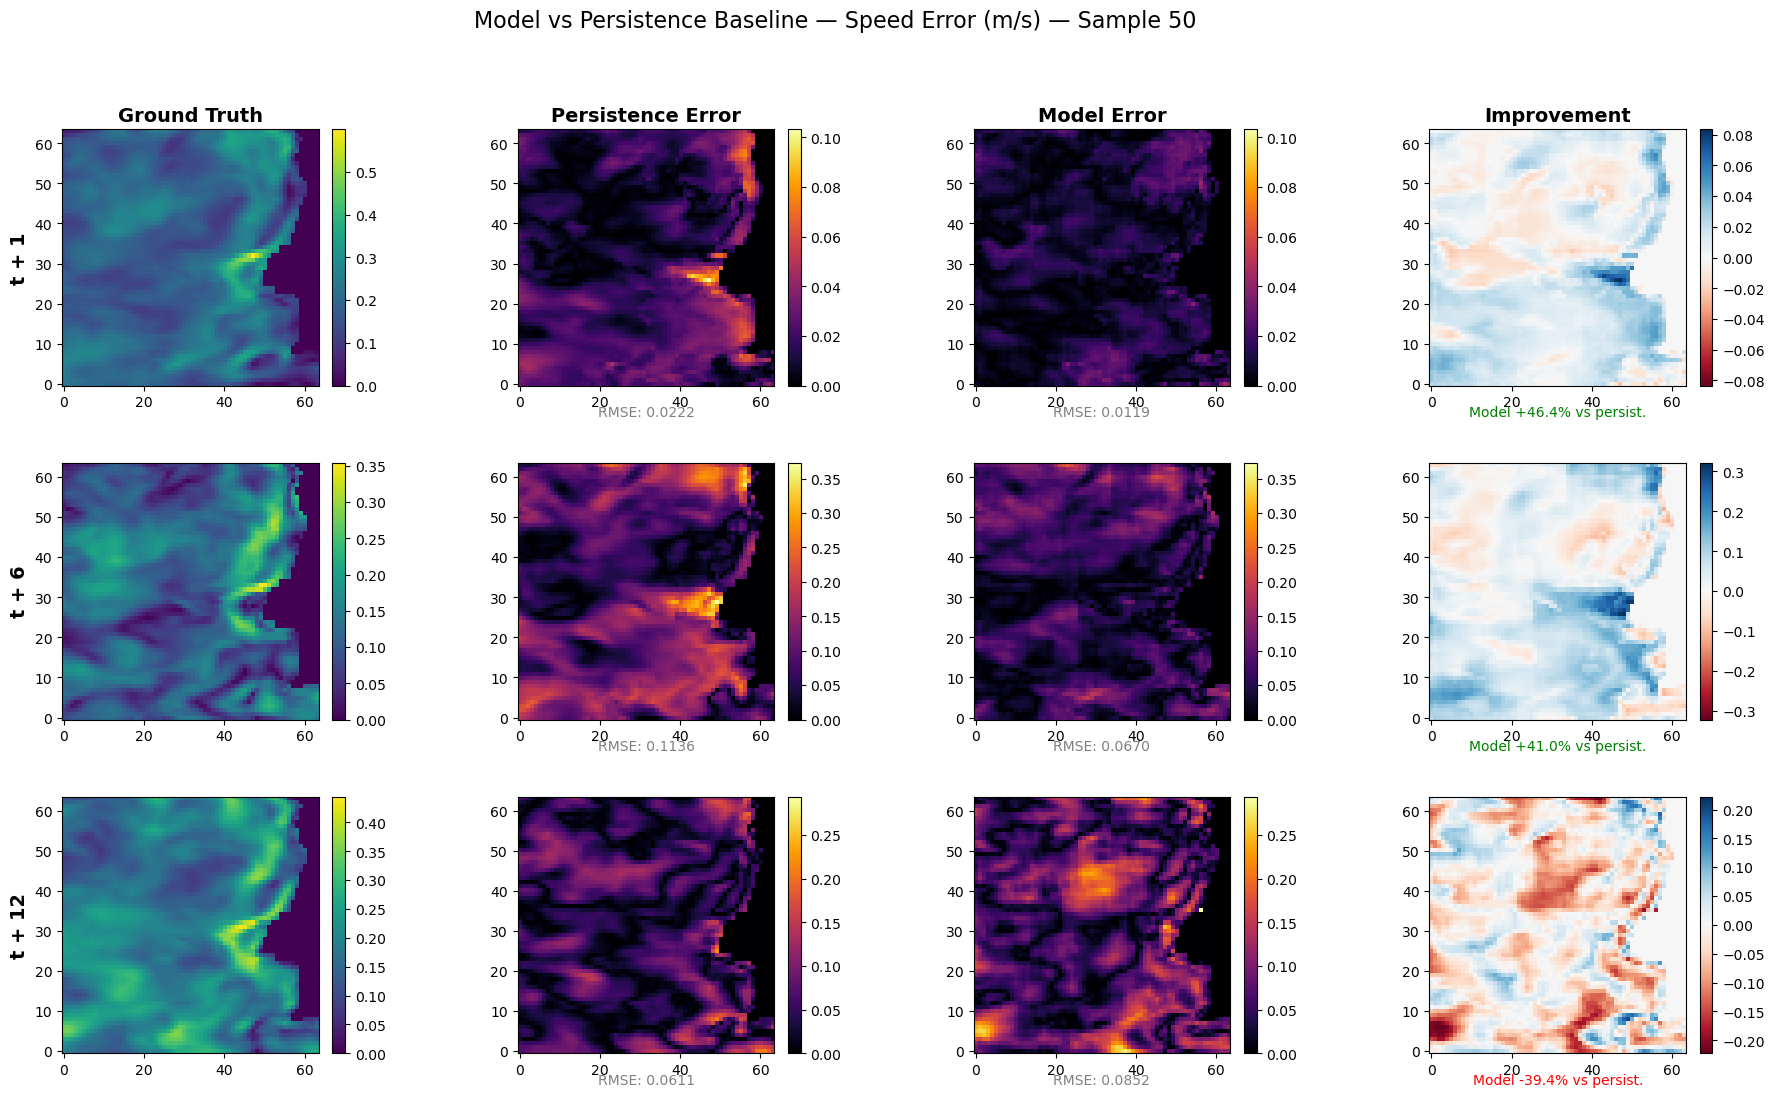

In [16]:
# --- Persistence Baseline vs Model Prediction Error ---

sample_idx = 50
steps_to_plot = [1, 6, 12]

# The "persistence" frame is the last frame of the input sequence
# i.e. the model's most recent observation, used naively as the forecast
persist_idx = sample_idx + seq_len - 1
persist_uv = uv_val[persist_idx]  # (2, H, W) in physical units
speed_persist = np.sqrt(persist_uv[0]**2 + persist_uv[1]**2)

fig, axes = plt.subplots(3, 4, figsize=(22, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.35)

cols = ['Ground Truth', 'Persistence Error', 'Model Error', 'Improvement']
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

for i, t_step in enumerate(steps_to_plot):
    pred_idx = t_step - 1
    gt_idx = sample_idx + seq_len + (t_step - 1)

    # Ground truth
    gt_uv = uv_val[gt_idx]
    speed_gt = np.sqrt(gt_uv[0]**2 + gt_uv[1]**2)

    # Model prediction
    pred_uv = inverse_zscore(preds_norm[pred_idx], stats)
    speed_pred = np.sqrt(pred_uv[0]**2 + pred_uv[1]**2)

    # Errors
    err_persist = np.abs(speed_persist - speed_gt)
    err_model   = np.abs(speed_pred - speed_gt)

    # Improvement: positive = model is better, negative = persistence is better
    improvement = err_persist - err_model

    # Shared error color scale for this row
    err_vmax = max(err_persist.max(), err_model.max())

    # Col 0: Ground Truth
    vmin_gt, vmax_gt = speed_gt.min(), speed_gt.max()
    im0 = axes[i, 0].imshow(speed_gt, cmap='viridis', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[i, 0].set_ylabel(f"t + {t_step}", fontsize=14, fontweight='bold')
    plt.colorbar(im0, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # Col 1: Persistence Error
    im1 = axes[i, 1].imshow(err_persist, cmap='inferno', origin='lower', vmin=0, vmax=err_vmax)
    plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Col 2: Model Error
    im2 = axes[i, 2].imshow(err_model, cmap='inferno', origin='lower', vmin=0, vmax=err_vmax)
    plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

    # Col 3: Improvement (diverging: blue = model better, red = persistence better)
    imp_lim = max(abs(improvement.min()), abs(improvement.max()), 1e-8)
    im3 = axes[i, 3].imshow(improvement, cmap='RdBu', origin='lower', vmin=-imp_lim, vmax=imp_lim)
    plt.colorbar(im3, ax=axes[i, 3], fraction=0.046, pad=0.04)

    # Add RMSE summary text
    rmse_persist = np.sqrt(np.mean(err_persist**2))
    rmse_model   = np.sqrt(np.mean(err_model**2))
    axes[i, 1].text(0.5, -0.12, f"RMSE: {rmse_persist:.4f}", transform=axes[i, 1].transAxes,
                     ha='center', fontsize=10, color='gray')
    axes[i, 2].text(0.5, -0.12, f"RMSE: {rmse_model:.4f}", transform=axes[i, 2].transAxes,
                     ha='center', fontsize=10, color='gray')
    pct = (1 - rmse_model / rmse_persist) * 100 if rmse_persist > 0 else 0
    axes[i, 3].text(0.5, -0.12, f"Model {pct:+.1f}% vs persist.", transform=axes[i, 3].transAxes,
                     ha='center', fontsize=10, color='green' if pct > 0 else 'red')

plt.suptitle(f"Model vs Persistence Baseline — Speed Error (m/s) — Sample {sample_idx}", fontsize=16)
plt.show()

Generating autoregressive rollout for 12 steps...


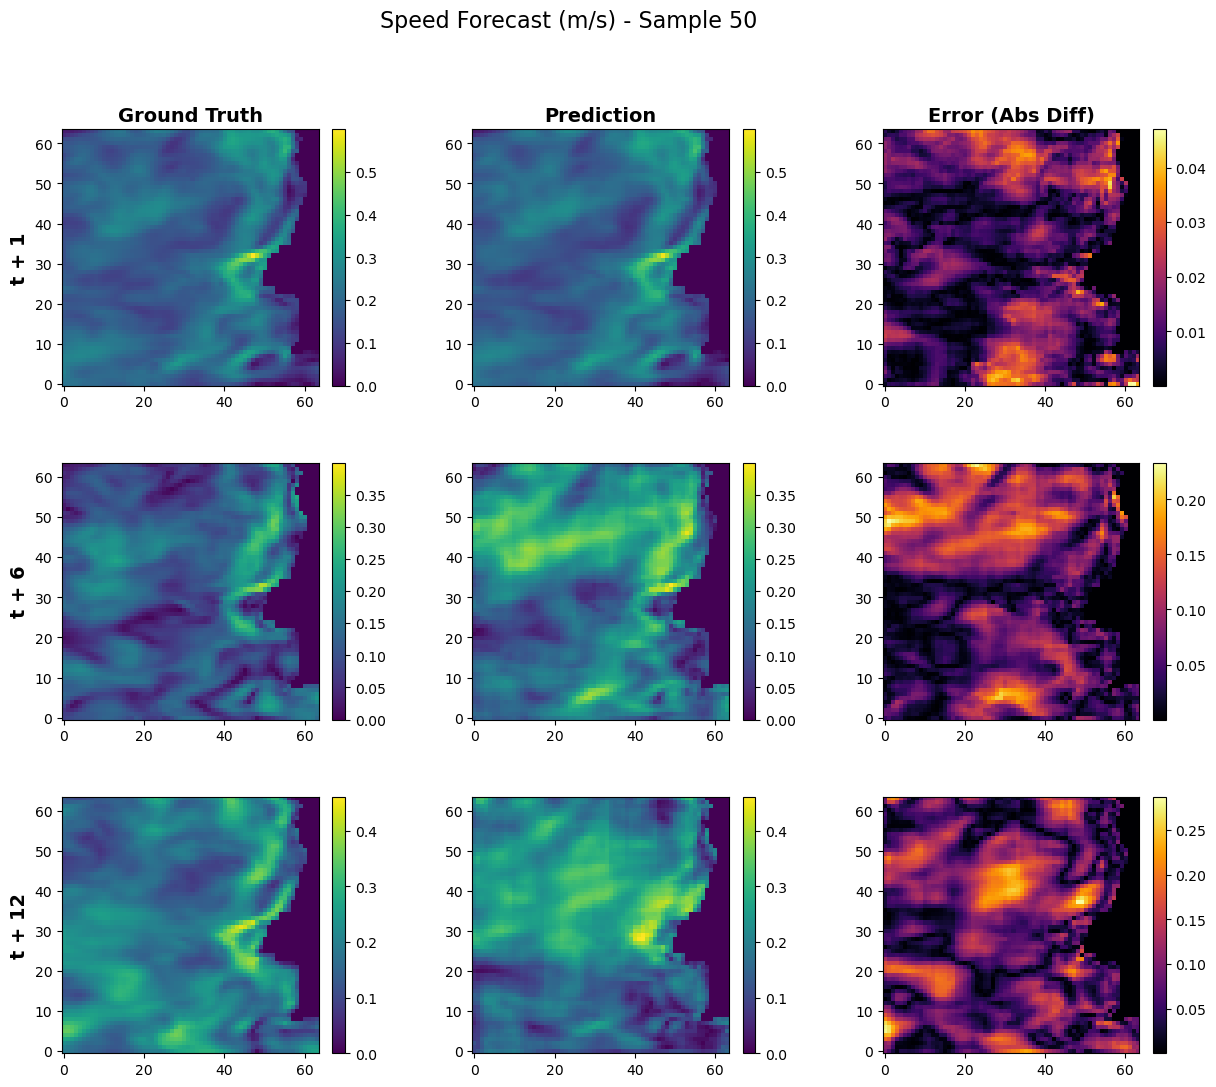

In [15]:
# --- Configuration ---
sample_idx = 50        # Index in the validation dataset
steps_to_plot = [1, 6, 12] # Time steps to visualize (t+1, t+6, t+12)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 1. Get Initial Input from Validation Set
# val_ds returns Tensors, so we just need to add the batch dimension
input_tensor, _ = val_ds[sample_idx] 

# Ensure input is (1, seq_len, 2, H, W)
if isinstance(input_tensor, np.ndarray):
    input_seq = torch.from_numpy(input_tensor).unsqueeze(0).float()
else:
    input_seq = input_tensor.unsqueeze(0).float()

input_seq = input_seq.to(device)

# 2. Generate 12 steps of predictions
print(f"Generating autoregressive rollout for 12 steps...")
preds_norm = predict_autoregressive(model, input_seq, steps=12, device=device)

# 3. Setup Plot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)
cols = ['Ground Truth', 'Prediction', 'Error (Abs Diff)']

# Set column titles
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

# 4. Loop through requested time steps and plot
for i, t_step in enumerate(steps_to_plot):
    # --- Indexing ---
    # Prediction index (0-based list): t_step - 1
    pred_idx = t_step - 1
    
    # Ground Truth index in 'uv_val' (raw data)
    # val_ds[sample_idx] covers [sample_idx ... sample_idx+seq_len-1]
    # So t+1 is at sample_idx + seq_len
    gt_idx = sample_idx + seq_len + (t_step - 1)
    
    # --- Retrieve Data ---
    # Get Prediction and un-normalize
    pred_uv = inverse_zscore(preds_norm[pred_idx], stats)
    
    # Get Ground Truth (direct from raw uv_val to compare physical units)
    gt_uv = uv_val[gt_idx]
    
    # --- Compute Speed (Magnitude) ---
    speed_pred = np.sqrt(pred_uv[0]**2 + pred_uv[1]**2)
    speed_gt   = np.sqrt(gt_uv[0]**2 + gt_uv[1]**2)
    speed_err  = np.abs(speed_pred - speed_gt)
    
    # --- Plotting ---
    # Determine common color scale for this row
    vmin = min(speed_gt.min(), speed_pred.min())
    vmax = max(speed_gt.max(), speed_pred.max())
    
    # Row i, Col 0: Ground Truth
    im1 = axes[i, 0].imshow(speed_gt, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[i, 0].set_ylabel(f"t + {t_step}", fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)
    
    # Row i, Col 1: Prediction
    im2 = axes[i, 1].imshow(speed_pred, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)
    
    # Row i, Col 2: Error
    im3 = axes[i, 2].imshow(speed_err, cmap='inferno', origin='lower')
    plt.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.suptitle(f"Speed Forecast (m/s) - Sample {sample_idx}", fontsize=16)
plt.show()

In [ ]:
# --- Configuration ---
sample_idx = 50
steps_to_plot = [1, 6, 12]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 1. Get Initial Input from Validation Set
input_tensor, _ = val_ds[sample_idx]

if isinstance(input_tensor, np.ndarray):
    input_seq = torch.from_numpy(input_tensor).unsqueeze(0).float()
else:
    input_seq = input_tensor.unsqueeze(0).float()

input_seq = input_seq.to(device)

# 2. Generate 12 steps of predictions (MEAN + LOGVAR)
print(f"Generating autoregressive rollout for 12 steps...")
# IMPORTANT: preds_norm should be a list/array of shape (steps, 4, H, W):
#   first 2 channels = mean (u,v), last 2 channels = logvar (u,v)
preds_norm = predict_autoregressive(model, input_seq, steps=12, device=device)

# 3. Setup Plot (add uncertainty column)
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3)
cols = ['Ground Truth', 'Prediction', 'Error (Abs Diff)', 'Uncertainty (σ_speed)']

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

# 4. Loop through requested time steps and plot
for i, t_step in enumerate(steps_to_plot):
    pred_idx = t_step - 1
    gt_idx = sample_idx + seq_len + (t_step - 1)

    # --- Retrieve prediction (normalized) ---
    pred_out = preds_norm[pred_idx]  # (4, H, W) expected
    pred_mu_norm = pred_out[:2]      # (2, H, W)
    pred_logvar_norm = pred_out[2:]  # (2, H, W)

    # --- Unnormalize mean to physical units ---
    pred_uv = inverse_zscore(pred_mu_norm, stats)  # (2, H, W) in m/s (or your units)

    # --- Convert predicted logvar (normalized space) -> variance in physical units ---
    # If y_phys = y_norm * std + mean, then var_phys = var_norm * std^2
    # stats.std should be shape (2,) or (2,1,1)
    var_norm = np.exp(pred_logvar_norm)

    std = np.asarray(stats.std)  # should be (2,) typically
    if std.ndim == 1:
        std = std[:, None, None]  # (2,1,1)

    var_phys = var_norm * (std ** 2)  # (2,H,W) physical variance for u,v
    sigma_u = np.sqrt(var_phys[0])
    sigma_v = np.sqrt(var_phys[1])

    # --- Ground truth from raw data (physical units) ---
    gt_uv = uv_val[gt_idx]  # (2, H, W) physical

    # --- Compute speed magnitude ---
    u_pred, v_pred = pred_uv[0], pred_uv[1]
    u_gt, v_gt     = gt_uv[0], gt_uv[1]

    speed_pred = np.sqrt(u_pred**2 + v_pred**2)
    speed_gt   = np.sqrt(u_gt**2   + v_gt**2)
    speed_err  = np.abs(speed_pred - speed_gt)

    # --- Uncertainty propagation to speed sigma ---
    eps = 1e-8
    denom = np.maximum(speed_pred, eps)
    ds_du = u_pred / denom
    ds_dv = v_pred / denom
    var_speed = (ds_du**2) * (sigma_u**2) + (ds_dv**2) * (sigma_v**2)
    sigma_speed = np.sqrt(np.maximum(var_speed, 0.0))

    # --- Plotting scales ---
    vmin = min(speed_gt.min(), speed_pred.min())
    vmax = max(speed_gt.max(), speed_pred.max())

    # Row i, Col 0: Ground Truth speed
    im1 = axes[i, 0].imshow(speed_gt, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[i, 0].set_ylabel(f"t + {t_step}", fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # Row i, Col 1: Pred speed
    im2 = axes[i, 1].imshow(speed_pred, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Row i, Col 2: Error
    im3 = axes[i, 2].imshow(speed_err, cmap='inferno', origin='lower')
    plt.colorbar(im3, ax=axes[i, 2], fraction=0.046, pad=0.04)

    # Row i, Col 3: Uncertainty (sigma of speed)
    im4 = axes[i, 3].imshow(sigma_speed, cmap='magma', origin='lower')
    plt.colorbar(im4, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.suptitle(f"Speed Forecast (m/s) + Uncertainty — Sample {sample_idx}", fontsize=16)
plt.show()

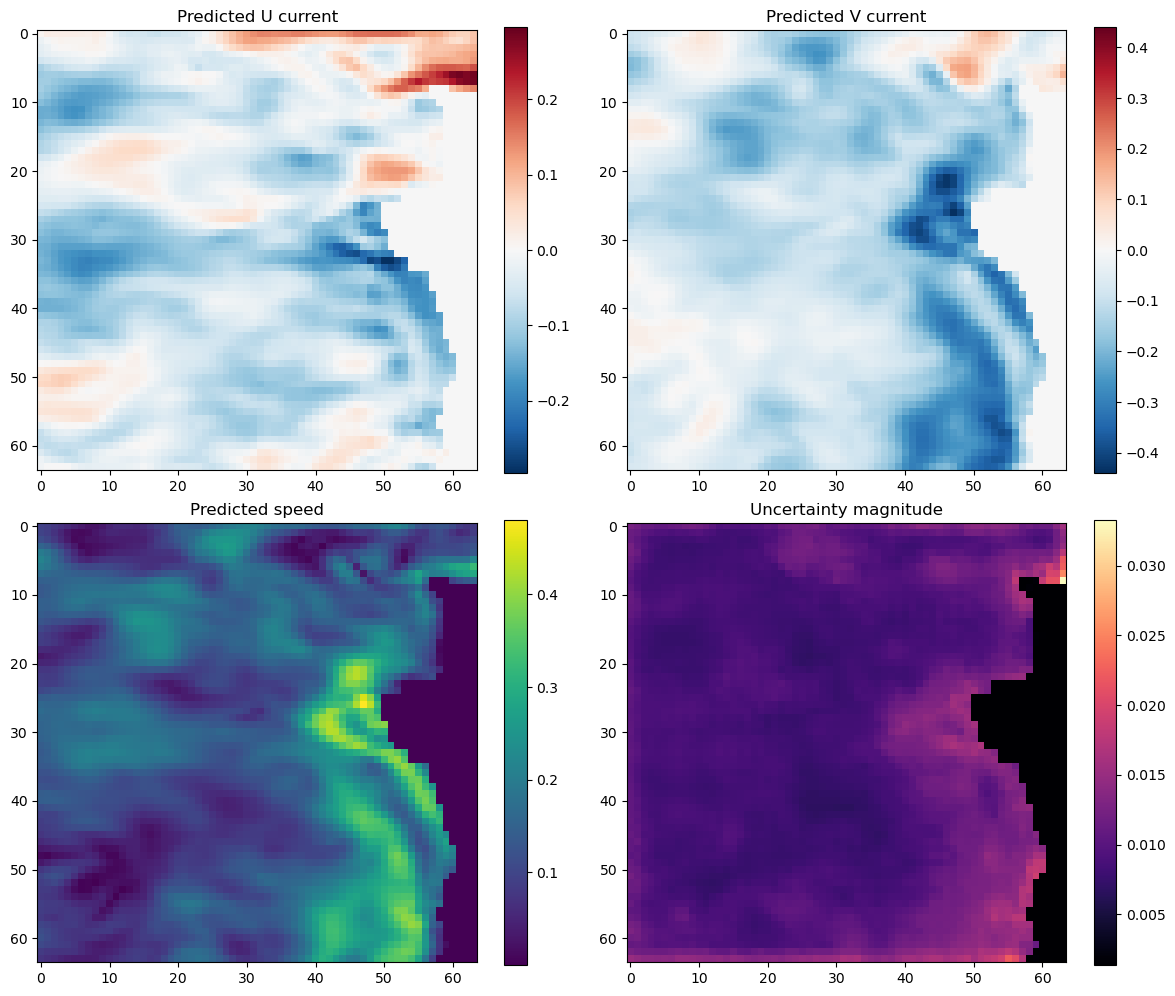

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ---- de-normalized u,v from earlier ----
# u_mu, v_mu, speed, unc already computed

# Diverging normalization centered at 0
u_lim = max(abs(u_mu.min()), abs(u_mu.max()))
v_lim = max(abs(v_mu.min()), abs(v_mu.max()))

u_norm = TwoSlopeNorm(vmin=-u_lim, vcenter=0, vmax=u_lim)
v_norm = TwoSlopeNorm(vmin=-v_lim, vcenter=0, vmax=v_lim)

fig, axes = plt.subplots(2,2, figsize=(12,10))

# ---- U component ----
im0 = axes[0,0].imshow(u_mu, cmap="RdBu_r", norm=u_norm)
axes[0,0].set_title("Predicted U current")
plt.colorbar(im0, ax=axes[0,0])

# ---- V component ----
im1 = axes[0,1].imshow(v_mu, cmap="RdBu_r", norm=v_norm)
axes[0,1].set_title("Predicted V current")
plt.colorbar(im1, ax=axes[0,1])

# ---- Speed (sequential) ----
im2 = axes[1,0].imshow(speed, cmap="viridis")
axes[1,0].set_title("Predicted speed")
plt.colorbar(im2, ax=axes[1,0])

# ---- Uncertainty magnitude ----
im3 = axes[1,1].imshow(unc, cmap="magma")
axes[1,1].set_title("Uncertainty magnitude")
plt.colorbar(im3, ax=axes[1,1])

plt.tight_layout()
plt.show()


### Notes on the uncertainty output
- `pred` is the **mean** current prediction (u,v).
- `sigma` is the **per-pixel standard deviation** (u,v) learned by the model (aleatoric uncertainty).
- `sigma` is currently in the **same normalized units** as training (because the model learns it in normalized space).  
  If you want `sigma` in physical units (m/s), we can convert it using your training min–max ranges.
